# Section 1: Data Preparation, cleaning and RF modeling

## Sec 1.1: Load packages and prepare variables

In [9]:
import numpy as np
import pandas as pd
import warnings
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import shap
warnings.filterwarnings('ignore')
df = pd.read_csv("XYZloan_default_selected_vars.csv")
df.shape

(80000, 89)

In [10]:
#Delete columns with null values or categorical variables
df.drop(['TD044','TD048','TD051','TD054','TD055','TD061','TD062','AP004','AP005','AP006','MB007'], axis=1, inplace=True)

#Filling missing value with median
for column in df.columns:
    # If the column is numeric, fill it with the median
    if pd.api.types.is_numeric_dtype(df[column]):
        median_val = df[column].median()
        df[column].fillna(median_val, inplace=True)

## Sec 1.2: Set target variables and predictors

In [11]:
# Choose the top 10 variables from RF model as predictors
target='loan_default'
predictors = ['AP003', 'TD013', 'TD009', 'TD005', 'MB005', 'CR015', 'TD014', 'AP001', 'TD010', 'TD001']

## Sec 1.3: Train-test split

In [12]:
train, test = train_test_split(df, test_size=0.2, random_state=42)
train['loan_default'].value_counts(dropna=False)

0    51662
1    12338
Name: loan_default, dtype: int64

## Sec 1.4: Random Forest modeling

In [13]:
rf_model = RandomForestRegressor(max_depth=6, random_state=0, n_estimators=10)
rf_model.fit(train[predictors], train[target])

RandomForestRegressor(max_depth=6, n_estimators=10, random_state=0)

# Section 2: Interprating features using SHAP values

## Sec 2.1: Summary plots

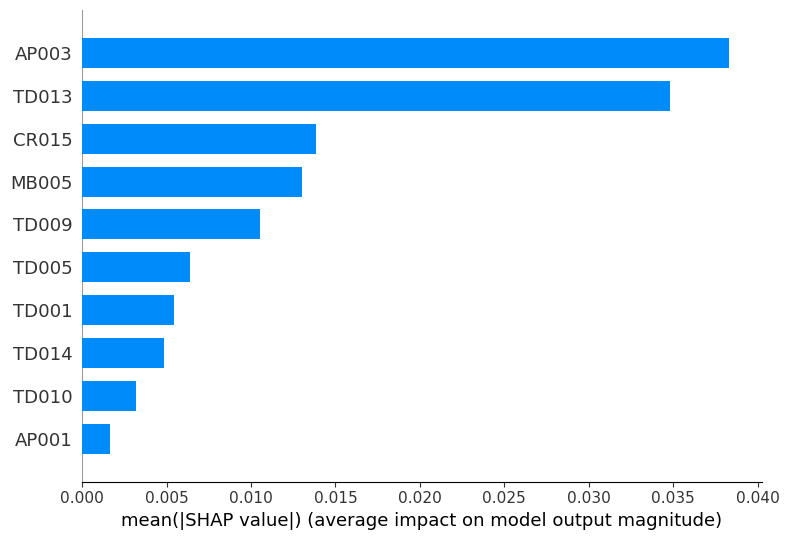

In [20]:
shap_values_dt = shap.TreeExplainer(rf_model).shap_values(train[predictors])
shap.summary_plot(shap_values_dt, train[predictors], plot_type="bar")

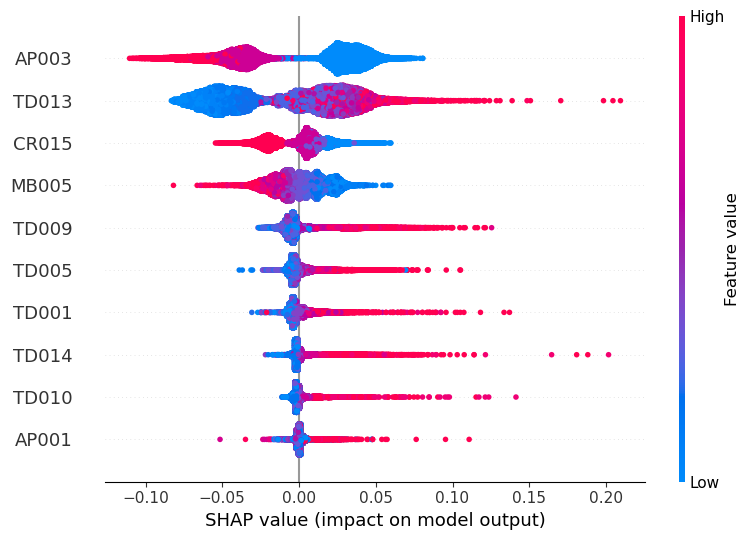

In [15]:
shap.summary_plot(shap_values_dt, train[predictors])

## Sec 2.2: Dependence plots

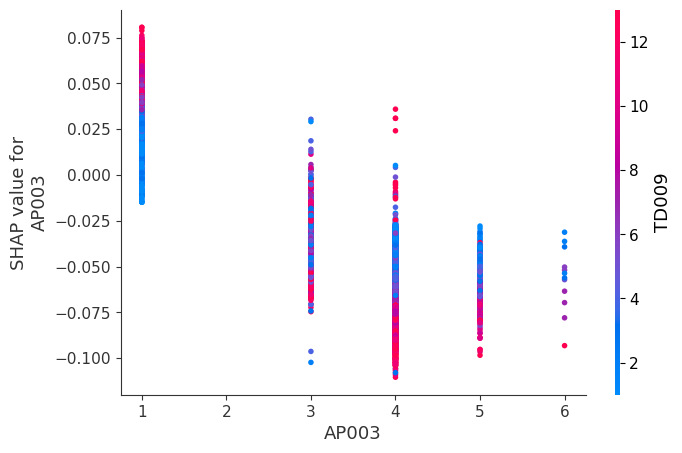

In [21]:
shap.dependence_plot('AP003', shap_values_dt, train[predictors])

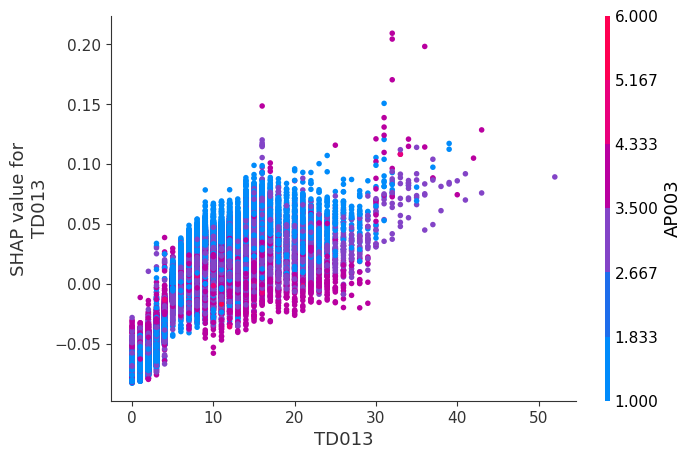

In [17]:
shap.dependence_plot('TD013', shap_values_dt, train[predictors])

In [18]:
# Get the predictions and put them with the test data.
X_output = test[predictors].copy()
X_output.loc[:,'predict'] = np.round(rf_model.predict(X_output),2)

# Randomly pick some observations
random_picks = np.arange(1,330,50) # Every 50 rows
S = X_output.iloc[random_picks]
S

,AP003,TD013,TD009,TD005,MB005,CR015,TD014,AP001,TD010,TD001,predict
44295,3,12,7,4,8.0,5,2,33,1,2,0.21
49540,3,5,5,4,7.0,5,1,31,0,2,0.13
28098,4,12,7,3,14.0,6,5,37,2,3,0.12
17370,1,22,15,5,3.0,5,6,22,3,3,0.37
70891,3,18,15,12,3.0,6,7,31,6,5,0.28
39087,3,2,2,2,5.0,6,0,33,0,0,0.08
41320,1,15,5,2,2.0,6,8,29,4,1,0.33


## Sec 2.3: Force plots

In [26]:
def shap_plot(j):
    explainerModel = shap.TreeExplainer(rf_model)
    shap_values_Model = explainerModel.shap_values(S)
    p = shap.force_plot(explainerModel.expected_value, shap_values_Model[j], S.iloc[[j]], matplotlib=True)
    return(p)


# # Initialize your Jupyter notebook with initjs(), otherwise you will get an error message.
# shap.initjs()

# # Write in a function
# def shap_plot(j):
#     explainerModel = shap.TreeExplainer(rf_model)
#     shap_values_Model = explainerModel.shap_values(S)
#     p = shap.force_plot(explainerModel.expected_value, shap_values_Model[j], S.iloc[[j]])
#     return(p)

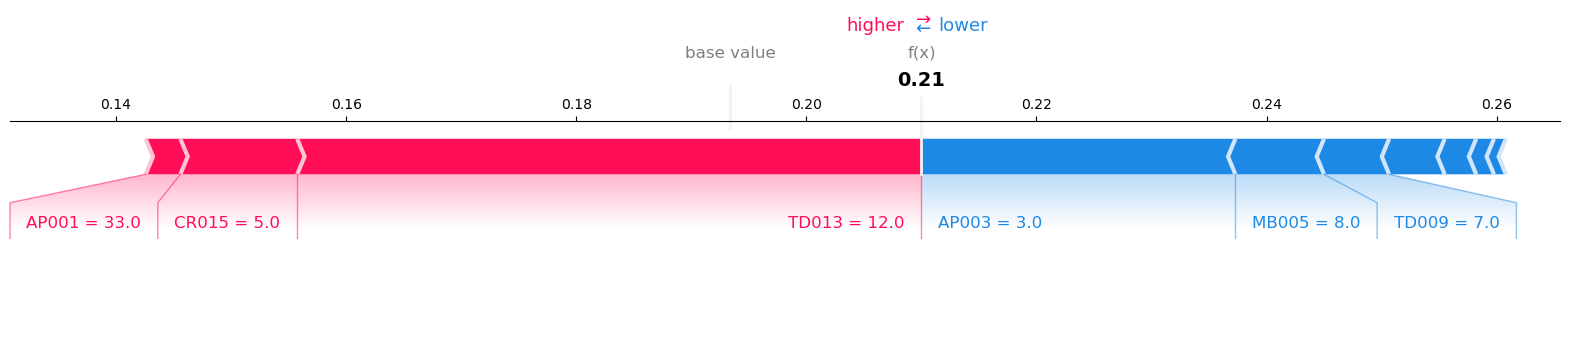

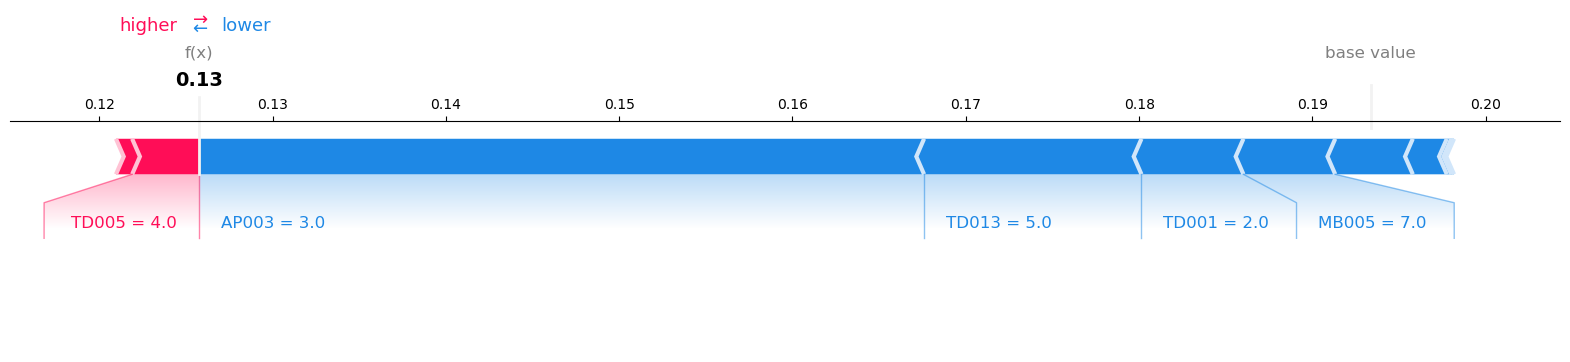

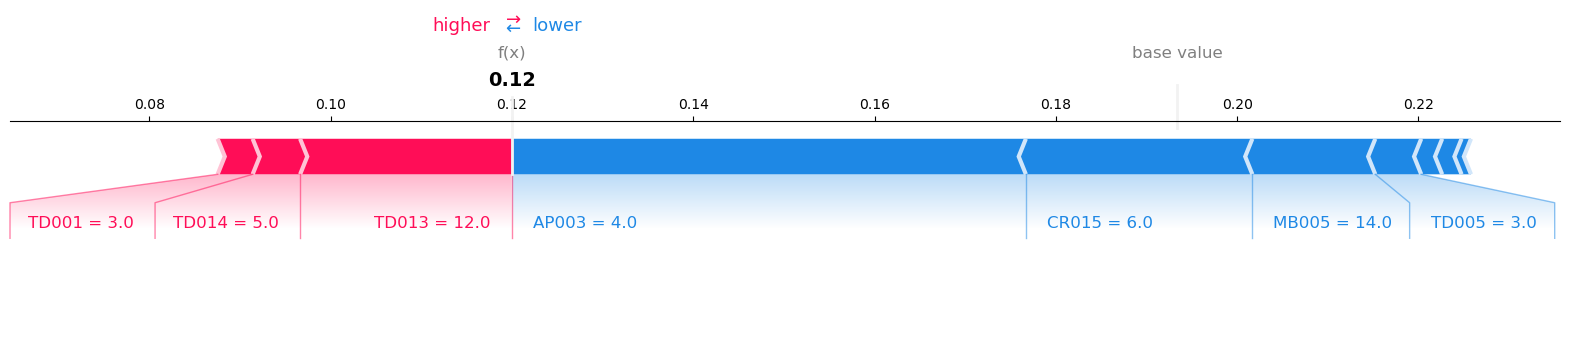

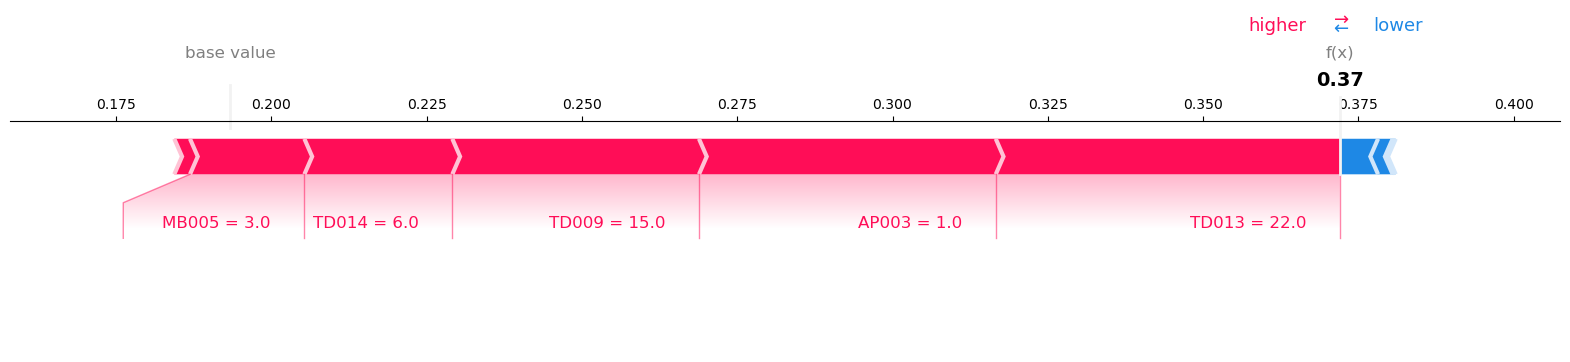

In [27]:
# Interpret Observation 1-4
sample_indices = [0, 1, 2, 3]

for index in sample_indices:
    shap_plot(index)

### Interpretation and analysis:

1. The feature importance is ranked in decreasing order, a feature with higher importance means it has larger impact on the performance, the features that has top 5 importance are 'AP003','TD013','CR015','MB005' and 'TD009';

* For 'AP003', when the feature value increase, the SHAP value is decreasing, large SHAP value of this feature is associated with small feature value; 
* While 'TD013' has the opposite relationship: high feature value is associated with large SHAP value;
* 'CR015' and 'MB005' has the same relationship with SHAP values, large SHAP values are associated with small feature value;
* 'TD009', 'TD005','TD001', 'TD014','TD010','AP001' are quite similar in SHAP values, high feature value is correlated with high SHAP value.

2. According to the SHAP value graphs, we can conclude that a loan default is associated with low 'AP003', high TD013', low 'CR015', low 'MB005', high 'TD009', 'TD005','TD001', 'TD014','TD010','AP001'.

3. 'AP003' interacts with 'TD009' most frequently, 'TD013' interacts with 'AP003' most frequently

4. 
* First observation: 'AP001', 'CR015', 'TD013' has a positive impact on loan default, they pushes the prediction to the right; while 'AP003', 'MB005' and 'TD009' has a negative impact on loan default, they pushes the prediction to the left, the output value is 0.21;
* Second observation: The output value is 0.13, only 'TD005' has positive impact on loan default, the features 'AP003', 'TD013', 'TD001', 'MB005' has negative impact on loan default;
* Third observation: The output value is 0.12, 'TD001', 'TD014' and 'TD013' has positve impact on loan default, while 'AP003', 'CR015', 'MB005','TD005' has negative impact;
* Forth observation: The output value is 0.37, 'MB005', 'TD014','TD009', 'AP003', 'TD013' has postive impact on loan default.